In [ ]:
import pandas as pd
import numpy as np 
df_macro_data = pd.read_csv("D:\\lion's den\\final_macro_data.csv", encoding='utf-8')
df_prices = pd.read_excel("D:\\lion's den\\ceny.xlsx")
roman_to_quarter = {'I': 'Q1', 'II': 'Q2', 'III': 'Q3', 'IV': 'Q4'}
    
# Split the column and extract components
df_prices['Year'] = df_prices['Kwartał'].str.split().str[1]
df_prices['Quarter'] = df_prices['Kwartał'].str.split().str[0].map(roman_to_quarter)
df_prices.drop(columns=['Kwartał'], inplace=True)
df_prices['Year'] = df_prices['Year'].astype(int)

df_macro_final = pd.merge(df_macro_data, df_prices, on=['Year', 'Quarter'], how='left')
df_macro_final.head()

quarter_to_month = {'Q1': '02', 'Q2': '05', 'Q3': '08', 'Q4': '11'}
df_macro_final['Date'] = df_macro_final['Year'].astype(str) + '-' + df_macro_final['Quarter'].map(quarter_to_month)
df_macro_final['Date'] = pd.to_datetime(df_macro_final['Date'])
df_macro_final.head()

df_macro_final['GDP'] = df_macro_final['GDP'].str.replace(",",".").astype(float)
df_macro_final.describe()
df_macro_final.dtypes

df_macro_final.drop(columns='Unemployment Rate', inplace=True)
df_macro_final.bfill(inplace=True)
df_macro_final.ffill(inplace=True)

# Get the existing column names as a list
columns = df_macro_final.columns.tolist()

# Replace columns at positions 7 and 8 with new names
columns[10] = 'secondary market prices'

# Assign the updated column list back to the dataframe
df_macro_final.columns = columns
    

                             const  Population  Interest Rate    income  \
const                          NaN         NaN            NaN       NaN   
Population                     NaN    1.000000       0.005177  0.885580   
Interest Rate                  NaN    0.005177       1.000000  0.353159   
income                         NaN    0.885580       0.353159  1.000000   
Construction Investments       NaN    0.376684       0.130691  0.402443   
Real Estate Market Services    NaN    0.523434       0.186853  0.505130   
Inflation                      NaN    0.549343       0.617166  0.579422   

                             Construction Investments  \
const                                             NaN   
Population                                   0.376684   
Interest Rate                                0.130691   
income                                       0.402443   
Construction Investments                     1.000000   
Real Estate Market Services                  0.897316   


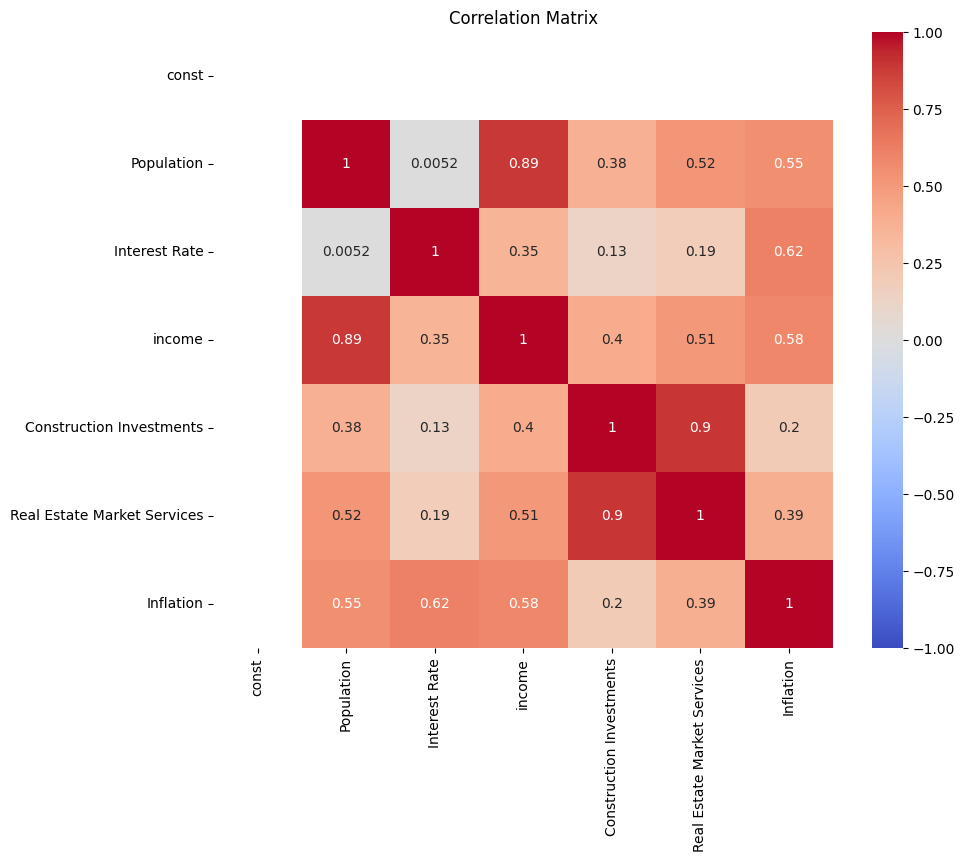

                               OLS Regression Results                              
Dep. Variable:     secondary market prices   R-squared:                       0.924
Model:                                 OLS   Adj. R-squared:                  0.915
Method:                      Least Squares   F-statistic:                     107.4
Date:                     Sun, 09 Mar 2025   Prob (F-statistic):           7.41e-28
Time:                             22:19:38   Log-Likelihood:                -484.30
No. Observations:                       60   AIC:                             982.6
Df Residuals:                           53   BIC:                             997.3
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [23]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Define the independent variables  
X = df_macro_final.iloc[:,3:-3]
y = df_macro_final['secondary market prices']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the summary of the model
model_summary = model.summary()


corr_matrix = X.corr()

# View the matrix
print(corr_matrix)

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

print(model_summary)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Try different ARIMA models and pick the best one
orders = [(1,1,0), (0,1,1), (1,1,1), (2,1,2)]
best_aic = float('inf')
best_order = None
best_model = None

print("Testing different ARIMA models:")
for order in orders:
    try:
        # Define exogenous variables
        exog = df_macro_final[['Interest Rate', 'income', 'Construction Investments', 'Inflation']]
        
        # Fit ARIMAX model !!! replace 'secondary market prices' with 'primary market prices' if needed !!!
        model = ARIMA(
            df_macro_final['secondary market prices'],
            exog=exog,
            order=order
        ).fit()
        
        # Check if this model is better (lower AIC)
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
            
        print(f"ARIMA{order} - AIC: {model.aic}")
        
    except Exception as e:
        print(f"Error with ARIMA{order}: {e}")

# Print summary of the best model
if best_model is not None:
    print(f"\nBest model is ARIMA{best_order} with AIC {best_aic}")
    print(best_model.summary())
    
    # Test residuals for stationarity and autocorrelation
    residuals = best_model.resid
    result = adfuller(residuals.dropna())
    
    print("\nModel Diagnostics:")
    print(f"ADF Test for Residuals - p-value: {result[1]}")
    print(f"Residuals are stationary: {result[1] < 0.05}")
    
    # Ljung-Box test for autocorrelation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30])
    print(f"Ljung-Box Test (lag 10) - p-value: {lb_test.iloc[0, 1]}")
    print(f"No autocorrelation in residuals: {lb_test.iloc[0, 1] > 0.05}")
    
    # If model diagnostics are poor, try with squared terms
    if result[1] >= 0.05 or lb_test.iloc[0, 1] <= 0.05:
        print("\nBasic model diagnostics suggest issues. Trying model with squared terms...")
        
        # Create squared terms
        df_squared = df_macro_final.copy()
        df_squared['Interest Rate_squared'] = df_macro_final['Interest Rate'] ** 2
        df_squared['income_squared'] = df_macro_final['income'] ** 2
        df_squared['Construction Investments_squared'] = df_macro_final['Construction Investments'] ** 2
        
        # Try models with squared terms
        best_aic_squared = float('inf')
        best_order_squared = None
        best_model_squared = None
        
        for order in orders:
            try:
                # Define exogenous variables with squared terms
                exog_squared = df_squared[['Interest Rate', 'income', 'Construction Investments',
                                          'Interest Rate_squared', 'income_squared', 'Construction Investments_squared']]
                
                # Fit ARIMAX model
                model_squared = ARIMA(
                    df_squared['secondary market prices'],
                    exog=exog_squared,
                    order=order
                ).fit()
                
                # Check if this model is better
                if model_squared.aic < best_aic_squared:
                    best_aic_squared = model_squared.aic
                    best_order_squared = order
                    best_model_squared = model_squared
                    
                print(f"ARIMA{order} with squared terms - AIC: {model_squared.aic}")
                
            except Exception as e:
                print(f"Error with ARIMA{order} squared model: {e}")
        
        # Compare with original model
        if best_model_squared is not None:
            print(f"\nBest model with squared terms is ARIMA{best_order_squared} with AIC {best_aic_squared}")
            print(f"Improvement over original model: {best_aic - best_aic_squared}")
            print(best_model_squared.summary())
            
            # Test residuals for the squared model
            residuals_squared = best_model_squared.resid
            result_squared = adfuller(residuals_squared.dropna())
            
            print("\nSquared Model Diagnostics:")
            print(f"ADF Test for Residuals - p-value: {result_squared[1]}")
            print(f"Residuals are stationary: {result_squared[1] < 0.05}")
            
            # Ljung-Box test for autocorrelation
            lb_test_squared = acorr_ljungbox(residuals_squared, lags=[10, 20, 30])
            print(f"Ljung-Box Test (lag 10) - p-value: {lb_test_squared.iloc[0, 1]}")
            print(f"No autocorrelation in residuals: {lb_test_squared.iloc[0, 1] > 0.05}")
            
            # Provide recommendation
            if result_squared[1] < 0.05 and lb_test_squared.iloc[0, 1] > 0.05:
                print("\nThe model with squared terms performs better. Recommend using this model.")
            else:
                print("\nBoth models have diagnostic issues. Consider alternative modeling approaches.")

Testing different ARIMA models:
ARIMA(1, 1, 0) - AIC: 857.5851528174942
ARIMA(0, 1, 1) - AIC: 858.2319627371197


C:\Users\Tadek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Tadek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Tadek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) - AIC: 853.8854616122809
ARIMA(2, 1, 2) - AIC: 846.2100838545842

Best model is ARIMA(2, 1, 2) with AIC 846.2100838545842
                                  SARIMAX Results                                  
Dep. Variable:     secondary market prices   No. Observations:                   60
Model:                      ARIMA(2, 1, 2)   Log Likelihood                -414.105
Date:                     Sun, 09 Mar 2025   AIC                            846.210
Time:                             22:20:08   BIC                            864.908
Sample:                                  0   HQIC                           853.509
                                      - 60                                         
Covariance Type:                       opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

C:\Users\Tadek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Define the percentage of data to use for training (e.g., 80%)
train_size = 0.8
train_index = int(len(df_macro_final) * train_size)

# Split the data
train_data = df_macro_final.iloc[:train_index]
test_data = df_macro_final.iloc[train_index:]

print(f"Training data shape: {train_data.shape}, Test data shape: {test_data.shape}")

# Use the best order from your previous analysis (replace with your actual best order)
best_order = (2, 1, 2)  # Example order, use the one that worked best from previous code

# Define exogenous variables
exog_vars = ['Interest Rate', 'income', 'Construction Investments', 'Population', 'Real Estate Market Services', 'Inflation']
exog_train = train_data[exog_vars]
exog_test = test_data[exog_vars]

# Train the model
model = ARIMA(
    train_data['secondary market prices'],
    exog=exog_train,
    order=best_order
).fit()

print("Model trained. Summary:")
print(model.summary())

# Forecast for the test period
forecast = model.get_forecast(steps=len(test_data), exog=exog_test)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate prediction metrics
actual = test_data['secondary market prices'].values
predictions = predicted_mean.values

mse = mean_squared_error(actual, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)
mape = np.mean(np.abs((actual - predictions) / actual)) * 100

print("\nPrediction Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Create a DataFrame with actual and predicted values for easier comparison
forecast_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predictions,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values,
    'Error': actual - predictions,
    'Percent Error': ((actual - predictions) / actual) * 100
})

print("\nForecast Results (first few rows):")
print(forecast_df.head())

# Print a summary of how many predictions are within different error margins
error_margins = [1, 2, 5, 10]  # percent error margins
for margin in error_margins:
    within_margin = (abs(forecast_df['Percent Error']) <= margin).sum()
    percent_within = (within_margin / len(forecast_df)) * 100
    print(f"Predictions within {margin}% error margin: {within_margin}/{len(forecast_df)} ({percent_within:.2f}%)")

Training data shape: (48, 12), Test data shape: (12, 12)


C:\Users\Tadek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model trained. Summary:
                                  SARIMAX Results                                  
Dep. Variable:     secondary market prices   No. Observations:                   48
Model:                      ARIMA(2, 1, 2)   Log Likelihood                -301.313
Date:                     Sun, 09 Mar 2025   AIC                            624.625
Time:                             22:22:42   BIC                            644.977
Sample:                                  0   HQIC                           632.284
                                      - 48                                         
Covariance Type:                       opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Interest Rate                  30.2531    100.533      0.301      0.763    -166.788     227.294
income          

C:\Users\Tadek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


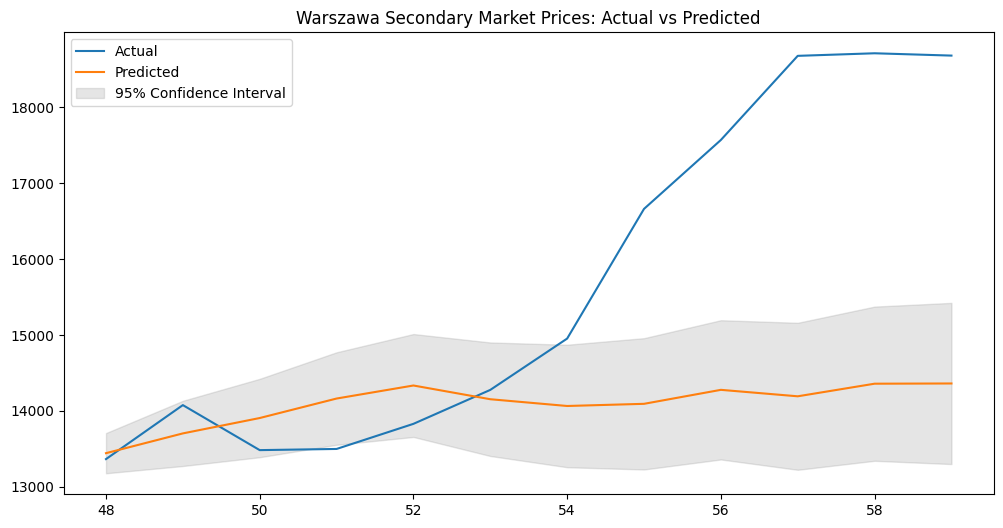

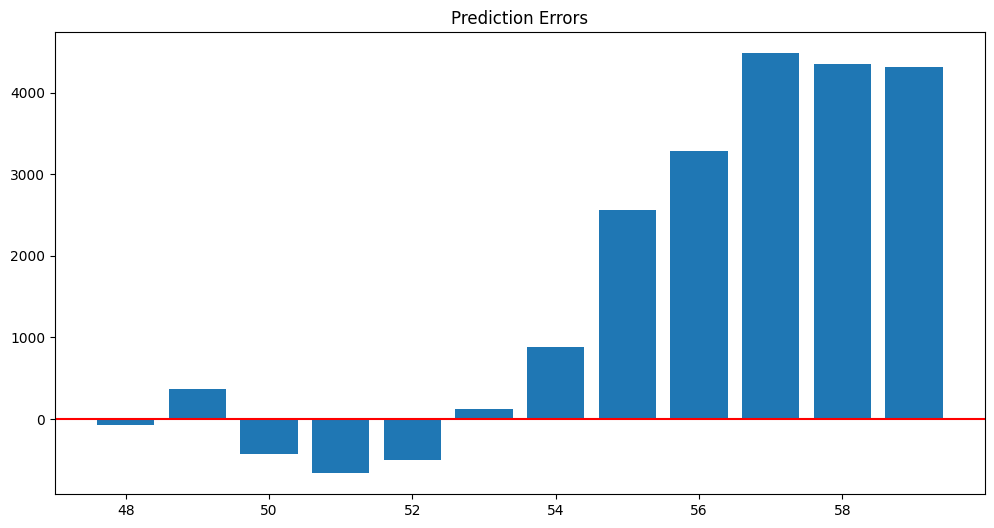

In [31]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.fill_between(test_data.index, 
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Warszawa Secondary Market Prices: Actual vs Predicted')
plt.legend()
plt.show()

# Plot the prediction errors
plt.figure(figsize=(12, 6))
plt.bar(test_data.index, forecast_df['Error'])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Prediction Errors')
plt.show()